# Ocean interior carbon storage: Changes in preformed vs regenerated carbon over the historic period (1850-2014)

In [1]:
%matplotlib inline
import xarray as xr
import intake
import numpy as np
from cmip6_preprocessing.preprocessing import read_data
import warnings
import matplotlib.pyplot as plt

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


## Connect to `Dask` cluster

In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.78.2:36773")
client

Client Scheduler: tcp://10.32.78.2:36773 Dashboard: /user/0000-0002-2993-7484/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


## Define functions for use later:
- _check_data_issues_       : parse errata reported by modeling centers from es-doc.org
- _calc_o2sat_gsw_          : calculate saturated oxygen concetration using the Gibbs Seawater Toolbox (TEOS10)
- _plot_atlantic_pacific_sections_ : plot arbitrary Atlantic and Pacific sections of scalar quantities or trends
- _compute_slope_           : calculate linear slope of input data

In [3]:
# Functions
def check_data_issues(catolog,issue_location="https://errata.es-doc.org/1/issue/retrieve-all",isurl=True):
    import urllib.request, json 
    import fnmatch
    import warnings
    
    if isurl:
        # Read the "es-doc.org" website (kinda slow if you need to access several times)
        with urllib.request.urlopen(issue_location) as url:
            esdoc_data = json.loads(url.read())
    else:
        # Read a JSON file downloaded from the "es-doc.org" website
        with open(issue_location) as json_file:
            esdoc_data = json.load(json_file)
        
    # How many issues
    print("Read in {} issues from es-doc.org".format(esdoc_data['count']))
    # each issue has these keys
    #print(dict(data['issues'][0]).keys())
    # print first issue details
    #print(dict(esdoc_data['issues'][0])['institute'])
    #print(dict(esdoc_data['issues'][0])['title'])
    #print(dict(esdoc_data['issues'][0])['description'])
    #print(dict(esdoc_data['issues'][0])['severity'])
    #print(dict(esdoc_data['issues'][0])['status'])
    #print(dict(esdoc_data['issues'][0])['datasets'])
    
    for ivar in range(len(catolog.df)):
        var='.'.join(['CMIP6',
            dict(catolog.df)['activity_id']   .iloc[ivar],
            dict(catolog.df)['institution_id'].iloc[ivar],
            dict(catolog.df)['source_id']     .iloc[ivar],
            dict(catolog.df)['experiment_id'] .iloc[ivar],
            dict(catolog.df)['member_id']     .iloc[ivar],
            dict(catolog.df)['table_id']      .iloc[ivar],
            dict(catolog.df)['variable_id']   .iloc[ivar],
            dict(catolog.df)['grid_label']    .iloc[ivar]
            ])
            #print(var)
    
        for issue in range(0,esdoc_data['count']):
            problem = fnmatch.filter(dict(esdoc_data['issues'][issue])['datasets'], '*'+var+'*')
            if problem:
                warning_string='''DATA ISSUE REPORTED\nFrom: {0}; Issue Severity: {1}; Status: {1}.\n{3}:\n{4}.'''
    
                warnings.warn((warning_string.format(
                        dict(esdoc_data['issues'][issue])['institute'].upper(),
                        dict(esdoc_data['issues'][issue])['severity'],
                        dict(esdoc_data['issues'][issue])['status'],
                        dict(esdoc_data['issues'][issue])['title'],
                        dict(esdoc_data['issues'][issue])['description'])))
    
def calc_o2sat_gsw(practical_salinity,potential_temperature):
    import gsw
    '''
    #Calculate Absolute Salinity
    gsw_as=xr.apply_ufunc(gsw.SA_from_SP,
                          practical_salinity,
                          pressure,
                          longitude,
                          latitude,
                          dask='parallelized',
                          output_dtypes=[float])
    
    #Calculate Conservative Temperature
    gsw_ct=xr.apply_ufunc(gsw.CT_from_t,
                          gsw_as,
                          potential_temperature,
                          pressure,
                          dask='parallelized',
                          output_dtypes=[float])

    #Calculate Oxygen Saturation
    gsw_o2sat=xr.apply_ufunc(gsw.O2sol,
                             gsw_as,
                             gsw_ct,
                             pressure,
                             longitude,
                             latitude,
                             dask='parallelized',
                             output_dtypes=[float])
    '''
    gsw_o2sat=xr.apply_ufunc(gsw.O2sol_SP_pt,
                             practical_salinity,
                             potential_temperature,
                             dask='parallelized',
                             output_dtypes=[float])
    
    return gsw_o2sat*1.0245e-3 # Convert umol/kg to mol/m3

def plot_atlantic_pacific_sections(data_dict,varname,units=None,fac=1,lev=np.arange(0,11,1),colors='viridis',cextend='both',plot_trend=False):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(ncols=2, nrows=len(data_dict.keys()),figsize=[15, 3*len(data_dict.keys())])
    A = 0
    for model in data_dict.keys():
        # Find mean longitude of arbitrary sections in the Atlantic (~340E) and Pacific (~200E) 
        if dic_dict[model].lon.min()<0:
            long=dic_dict[model].lon.values
            lonmean=np.mean(np.where(long<0, long+360, long),axis=0)
        else:
            lonmean=dic_dict[model].lon.mean('y').values
            
        xloca=np.abs(lonmean-340).argmin()
        xlocp=np.abs(lonmean-200).argmin()
        
        alatgrid,levgrid=np.meshgrid(data_dict[model].lat.isel(x=xloca),data_dict[model].lev)
        platgrid,levgrid=np.meshgrid(data_dict[model].lat.isel(x=xlocp),data_dict[model].lev)

        if plot_trend:
            aslope = compute_slope(data_dict[model][varname].isel(x=xloca)
                                   .chunk({'time': -1,'y': 100}))
            aslope = aslope.mean('member_id')*12 # in mol/m^3/year

            pslope = compute_slope(data_dict[model][varname].isel(x=xlocp)
                                   .chunk({'time': -1,'y': 100}))
            pslope = pslope.mean('member_id')*12 # in mol/m^3/year
    
            cba=axes[A,0].contourf(alatgrid,levgrid,(aslope*fac),cmap=colors,levels=lev,extend=cextend)
            cbp=axes[A,1].contourf(platgrid,levgrid,(pslope*fac),cmap=colors,levels=lev,extend=cextend)
            
            cbara=fig.colorbar(cba,ax=axes[A,0],ticks=lev[::2],extend=cextend)
            cbara.solids.set_edgecolor("face")
            cbarp=fig.colorbar(cbp,ax=axes[A,1],ticks=lev[::2],extend=cextend)
            cbarp.solids.set_edgecolor("face")
            
            axes[A,0].set_title(' '.join(['Atlantic',model,varname.upper(),'trend',units]))
            axes[A,0].set_facecolor('black')
            axes[A,1].set_title(' '.join(['Pacific' ,model,varname.upper(),'trend',units]))
            axes[A,1].set_facecolor('black')
        else:
            cba=axes[A,0].contourf(alatgrid,levgrid,data_dict[model][varname]
                               .isel(time=slice(-13,-1)).mean({'time','member_id'}).isel(x=xloca)*fac,
                               levels=lev,cmap=colors,extend=cextend)

            cbp=axes[A,1].contourf(platgrid,levgrid,data_dict[model][varname]
                               .isel(time=slice(-13,-1)).mean({'time','member_id'}).isel(x=xlocp)*fac,
                               levels=lev,cmap=colors,extend=cextend)
            
            cbara=fig.colorbar(cba,ax=axes[A,0],ticks=lev[::2],extend=cextend)
            cbara.solids.set_edgecolor("face")
            cbarp=fig.colorbar(cbp,ax=axes[A,1],ticks=lev[::2],extend=cextend)
            cbarp.solids.set_edgecolor("face")
            
            axes[A,0].set_title(' '.join(['Atlantic',model,varname.upper(),units]))
            axes[A,0].set_facecolor('black')
            axes[A,1].set_title(' '.join(['Pacific' ,model,varname.upper(),units]))
            axes[A,1].set_facecolor('black')

        #if model == 'MIROC-ES2L':
        #    # This model is half Arctic!!
        #    axes[A,0].set_xlim(75,data_dict[model][varname].y.min())
        #    axes[A,1].set_xlim(data_dict[model][varname].y.min(),75)
        #else:
        #    axes[A,0].set_xlim(data_dict[model][varname].y.max(),data_dict[model][varname].y.min())
        axes[A,0].set_xlim(80,-90)
        axes[A,0].set_ylim(6000,0)
        axes[A,0].set_xlabel("")  
        axes[A,0].set_ylabel("")  

        axes[A,1].set_xlim(-90,60)
        axes[A,1].set_ylim(6000,0)
        axes[A,1].set_xlabel("")  
        axes[A,1].set_ylabel("") 
        A +=1  
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    return fig, axes
    
    return xloca, xlocp

def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

## Open the ESM Datastore, either on the Google Cloud or Cheyenne at NCAR

In [4]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    #col = intake.open_esm_datastore("../catalogs/pangeo-cmip6_update_2019_10_18.json")    
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6-noQC.json")

#import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

## Start reading CMIP6 data first for `dic` and then `o2`, `thetao`, and `so` (salinity) 

In [5]:
# read all data with dic from regridded models 
#  (Cant use "cmip6_preprocessing.preprocessing.read_data" 
#  because "lon" is not a variable, even though it's a coordinate)
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id = ['historical'], 
                 grid_label    = 'gr',
                 table_id      = 'Omon',
                 variable_id   = 'dissic')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)
    
models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
models=models-{'GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)
print(models)

# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs ={'chunks':{'time':50}, 'decode_times': False})
dic_dict={}
for model in dset_dict.keys():
    dic_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
    lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
    dic_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
    dic_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
    
# read all data with dic native models
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id = ['historical'], 
                 grid_label    = 'gn',
                 table_id      = 'Omon',
                 variable_id   = 'dissic')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)
    
models = models.intersection({model for model in cat.df.source_id.unique().tolist()})
models=models-{'GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)
print(models)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = ['gn'],
                          variable_id   = ['dissic'],
                          table_id      = ['Omon'],
                          source_id     =  models,
                          required_variable_id = ['dissic'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        dic_dict[model]=dset_dict[model]

# Correct CESM2 has depth in cm
dic_dict['CESM2']['lev']=dic_dict['CESM2']['lev']/100

print(dic_dict.keys())

Read in 81 issues from es-doc.org


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NOAA-GFDL; Issue Severity: medium; Status: medium.
Wrong branch_time_in_parent attribute for GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments:
The GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments branched from piControl at year 251, which was 250 years (91250 days) after 0001-1-1 (piControl time-axis units). Therefore, the branch_time_in_parent is 91250, not 36500..
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NOAA-GFDL; Issue Severity: critical; Status: critical.
Incorrect emissions in December 2014:
The published data (for all variables) include an error in the natural emissions of all species during the latter half of December 2014. Thus, all model simulation results are not valid for this time period. This dataset is being retracted and replaced by corrected results..


['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 'GFDL-CM4']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 4 group(s)
Read in 81 issues from es-doc.org
['UKESM1-0-LL', 'CNRM-ESM2-1', 'MIROC-ES2L', 'CESM2', 'CanESM5', 'IPSL-CM6A-LR']
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of var

In [6]:
models = set(uni_dict['source_id']['values']) # all the models
# read all data with O2 from regridded models 
#  (Cant use "cmip6_preprocessing.preprocessing.read_data" 
#  because "lon" is not a variable, even though it's a coordinate)
bgc_dict={}
cat = col.search(experiment_id  =['historical'],
                 grid_label     = 'gr',
                 variable_id    = 'o2',
                 table_id       = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in dic_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

print(models)

# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs= {'chunks':{'time':50}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        bgc_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        bgc_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        bgc_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with O2 native models
models = set(uni_dict['source_id']['values']) # all the models
cat = col.search(experiment_id  =['historical'],
                 grid_label     = 'gn',
                 variable_id    = 'o2',
                 table_id       = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in dic_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                         experiment_id = ['historical'],
                         grid_label    = ['gn'],
                         variable_id   = ['o2'],
                         table_id      = ['Omon'],
                         source_id     = models,
                         required_variable_id = ['o2'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            bgc_dict[model]=dset_dict[model]
print(bgc_dict.keys())

# Get DIC into bgc_dict for calculating carbon components
for model in bgc_dict.keys():
    bgc_dict[model]['dissic']=dic_dict[model]['dissic']

Read in 81 issues from es-doc.org
[]
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NCAR; Issue Severity: critical; Status: critical.
Incorrect ocean oxygen data:
Certain ocean oxygen fields are erroneous and should not be used..
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NOAA-GFDL; Issue Severity: medium; Status: medium.
Wrong branch_time_in_parent attribute for GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments:
The GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments branched from piControl at year 251, which was 250 years (91250 days) after 0001-1-1 (piControl time-axis units). Therefore, the branch_time_in_parent is 91250, not 36500..


Read in 81 issues from es-doc.org
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL'])


In [7]:
# read all data with thetao, and so
theta_dict={}
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gr',
                 variable_id   = 'thetao',
                 table_id      = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = set(uni_dict['source_id']['values']) # all the models
models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in bgc_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':50}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        theta_dict[dset_dict[model].source_id]=dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        theta_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        theta_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with theta native models (excluding GFDL, which didnt report O2 on native grid)
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gn',
                 variable_id   = 'thetao',
                 table_id      = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = set(uni_dict['source_id']['values']) # all the models
models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in bgc_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = 'gn',
                          variable_id   = 'thetao',
                          table_id      = 'Omon',
                          source_id     =  models,
                          required_variable_id = ['thetao'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            theta_dict[model]=dset_dict[model]
print(theta_dict.keys())

salt_dict={}
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gr',
                 variable_id   = 'so',
                 table_id      = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = set(uni_dict['source_id']['values']) # all the models
models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in bgc_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':30}, 'decode_times': False})
for model in dset_dict.keys():
    if dset_dict[model].source_id in models:
        salt_dict[dset_dict[model].source_id]       =dset_dict[model].rename({'lon':'x','lat':'y'})
        lon ,lat = np.meshgrid(dset_dict[model].lon.values,dset_dict[model].lat.values)
        salt_dict[dset_dict[model].source_id]['lon']=xr.DataArray(lon, dims=['y', 'x'])
        salt_dict[dset_dict[model].source_id]['lat']=xr.DataArray(lat, dims=['y', 'x'])
        
# read all data with so native models (excluding GFDL, which didnt report O2 on native grid)
cat = col.search(experiment_id = ['historical'],
                 grid_label    = 'gn',
                 variable_id   = 'so',
                 table_id      = 'Omon')
# Check the ES-DOC website for CMIP6 data issues if using the noQC catolog
if col.esmcol_path.find('noQC')!=-1:
    check_data_issues(cat,issue_location="../catalogs/es-doc-retrieve-all-issues-20191029.json",isurl=False)

models = set(uni_dict['source_id']['values']) # all the models
models = models.intersection({model for model in cat.df.source_id.unique().tolist()}).intersection({model for model in bgc_dict})
models = models-{'CESM2-WACCM','GFDL-CM4','GISS-E2-1-G-CC','GISS-E2-1-G','AWI-CM-1-1-MR'}
models = list(models)

with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    dset_dict = read_data(col,
                          experiment_id = ['historical'],
                          grid_label    = ['gn'],
                          variable_id   = ['so'],
                          table_id      = ['Omon'],
                          source_id     =  models,
                          required_variable_id = ['so'])

# Append or overwrite the regridded values with those on native grid
    for model in dset_dict.keys():
        if model in models:
            salt_dict[model]=dset_dict[model]
print(salt_dict.keys())

Read in 81 issues from es-doc.org


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NOAA-GFDL; Issue Severity: medium; Status: medium.
Wrong branch_time_in_parent attribute for GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments:
The GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments branched from piControl at year 251, which was 250 years (91250 days) after 0001-1-1 (piControl time-axis units). Therefore, the branch_time_in_parent is 91250, not 36500..


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
Read in 81 issues from es-doc.org


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: MOHC; Issue Severity: high; Status: high.
Incorrect latitude & longitude coordinate data in some Omon datasets:
Due to a processing system error the latitude and longitude data being written to the published files is incorrect and may be up to half a degree out. Data that should have been given latitudes and longitudes corresponding to the T points of the eORCA1 grid was instead given coordinate values for the U or V points (or vice-versa) depending on processing order.  Affected data has been withdrawn and replacement data sets will be published in due course..


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL'])
Read in 81 issues from es-doc.org


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: NOAA-GFDL; Issue Severity: medium; Status: medium.
Wrong branch_time_in_parent attribute for GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments:
The GFDL-CM4 1pctCO2, abrupt-4xCO2, and historical experiments branched from piControl at year 251, which was 250 years (91250 days) after 0001-1-1 (piControl time-axis units). Therefore, the branch_time_in_parent is 91250, not 36500..


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
Read in 81 issues from es-doc.org


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: DATA ISSUE REPORTED
From: MOHC; Issue Severity: high; Status: high.
Incorrect latitude & longitude coordinate data in some Omon datasets:
Due to a processing system error the latitude and longitude data being written to the published files is incorrect and may be up to half a degree out. Data that should have been given latitudes and longitudes corresponding to the T points of the eORCA1 grid was instead given coordinate values for the U or V points (or vice-versa) depending on processing order.  Affected data has been withdrawn and replacement data sets will be published in due course..


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 5 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
MIROC-ES2L
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
UKESM1-0-LL
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL'])


## Plot Atlantic and Pacific meridional sections of DIC for each model

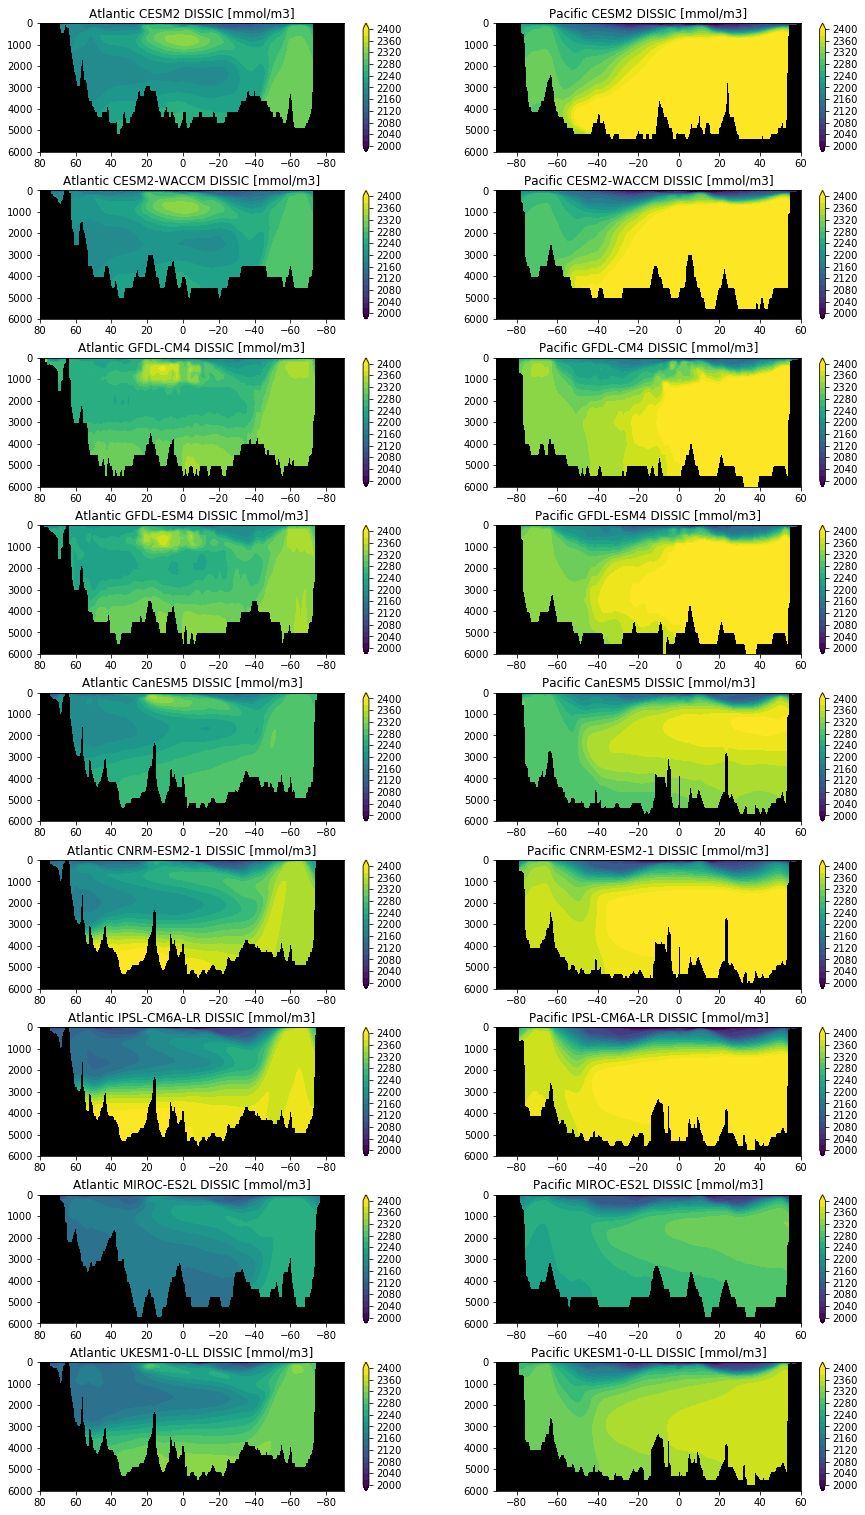

In [8]:
fig, axes = plot_atlantic_pacific_sections(dic_dict,"dissic",units="[mmol/m3]",fac=1e3,lev=np.arange(2000,2420,20))

## Calculate Saturated Oxygen for each model

In [9]:
for model in bgc_dict.keys():
    print(model)
    bgc_dict[model]['gsw_o2sat']=calc_o2sat_gsw( salt_dict[model]['so'],
                                                theta_dict[model]['thetao'])
                                               #   bgc_dict[model]['lat'],
                                               #   bgc_dict[model]['lon'],
                                               #   bgc_dict[model]['lev'])
    bgc_dict[model]['gsw_o2sat'] =  bgc_dict[model]['gsw_o2sat'].chunk({'time':5})
    bgc_dict[model]['aou']       = (bgc_dict[model]['gsw_o2sat']-bgc_dict[model].o2).chunk({'time':5})
    bgc_dict[model]['creg']      =  bgc_dict[model]['aou'].chunk({'time':5})*(117/170)
    bgc_dict[model]['cpre']      = (bgc_dict[model]['dissic']-bgc_dict[model]['creg']).chunk({'time':5})

CanESM5
CNRM-ESM2-1
IPSL-CM6A-LR
MIROC-ES2L
UKESM1-0-LL


## Plot regenerated carbon (`CREG=R_c:o2.AOU`) and preformed carbon (`CPRE=DIC-CREG`)

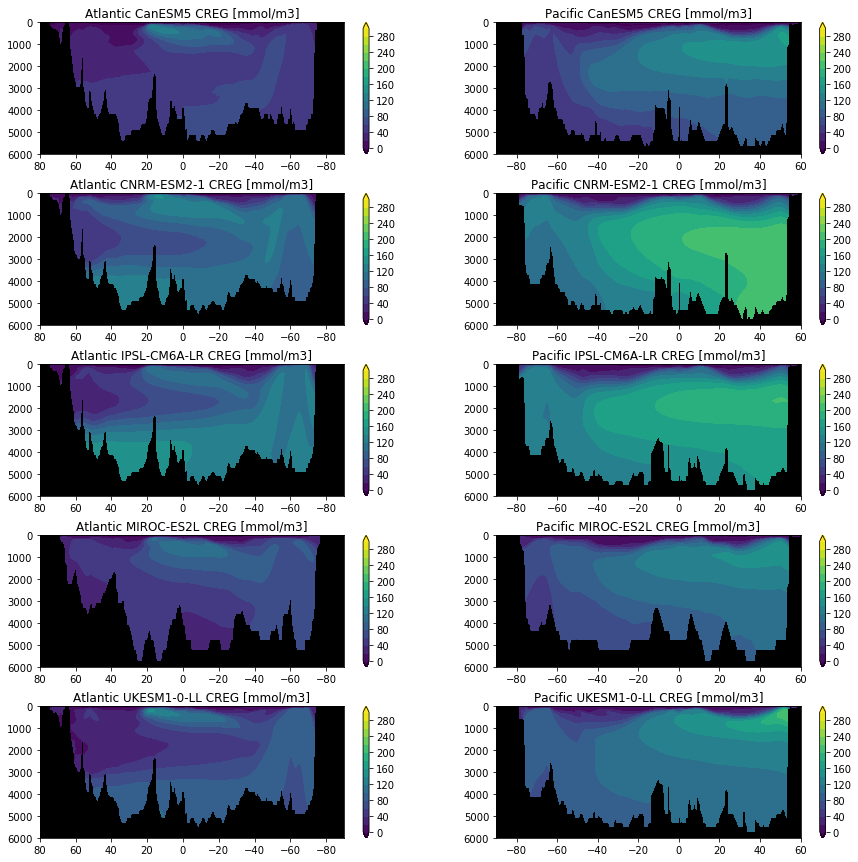

In [10]:
fig, axes = plot_atlantic_pacific_sections(bgc_dict,"creg",units="[mmol/m3]",fac=1e3,lev=np.arange(0,320,20))

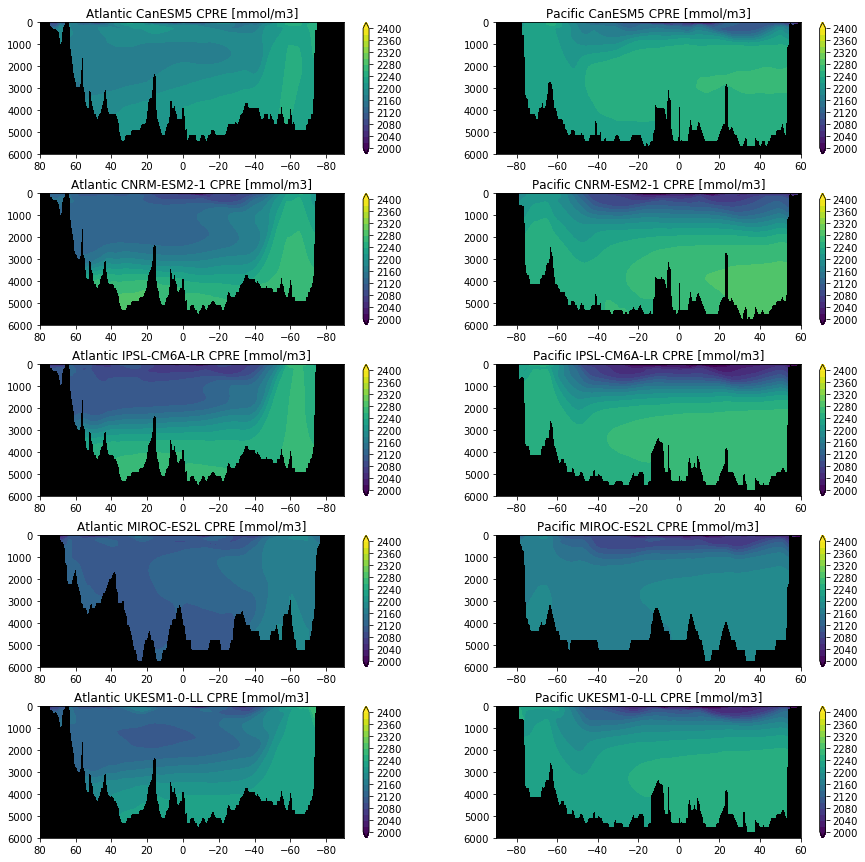

In [11]:
fig, axes = plot_atlantic_pacific_sections(bgc_dict,"cpre",units="[mmol/m3]",fac=1e3,lev=np.arange(2000,2420,20))

## Compute linear trend in `DIC`, `Cpre`, and `Creg`.

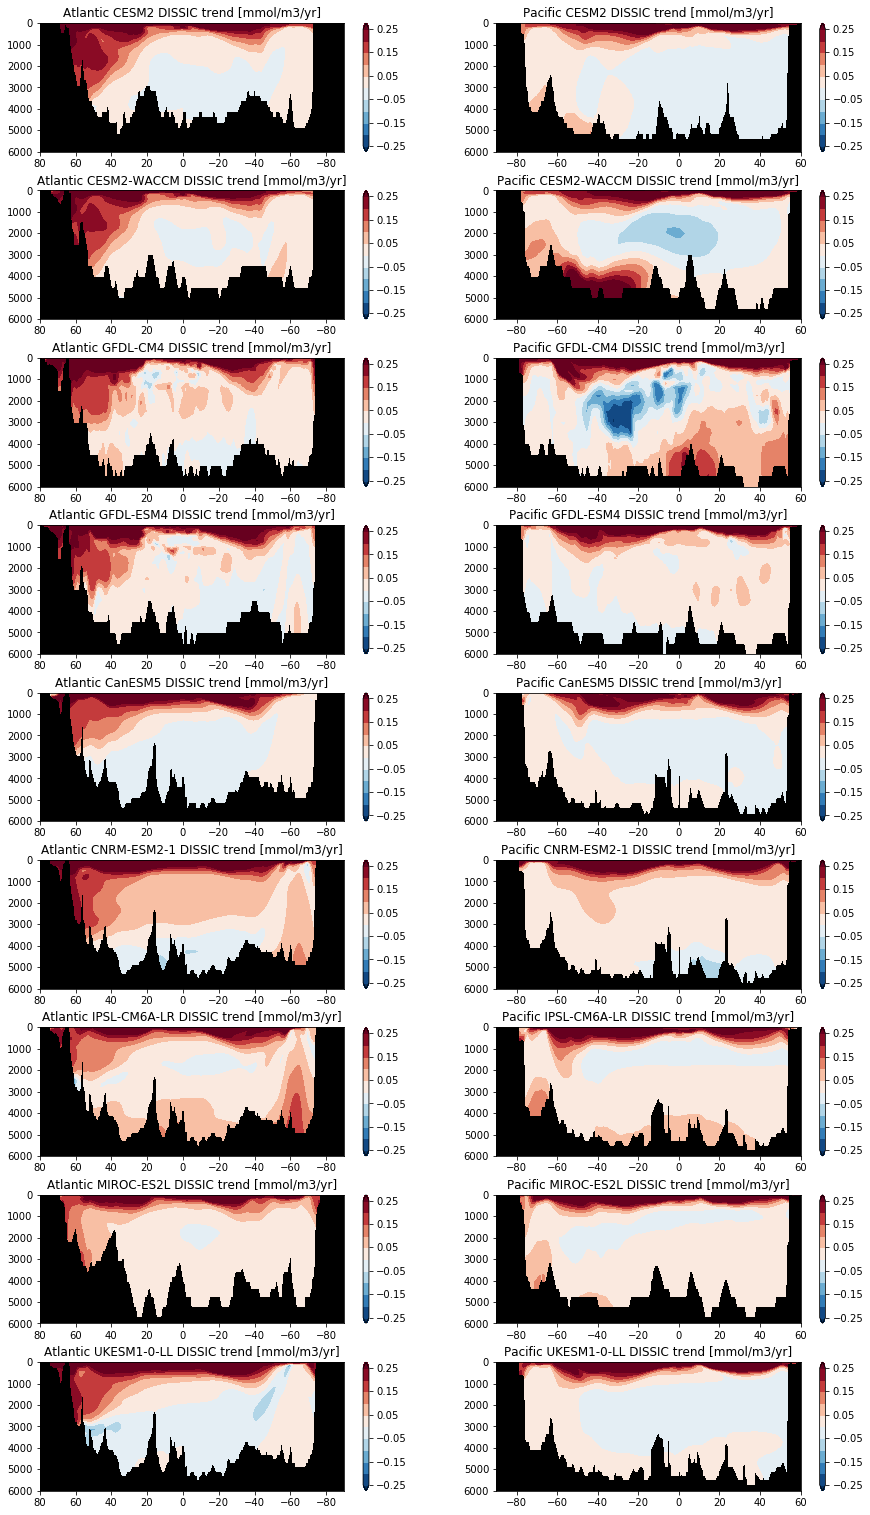

In [12]:
fig, axes = plot_atlantic_pacific_sections(dic_dict,"dissic",plot_trend=True,
                                           units="[mmol/m3/yr]",fac=1e3,lev=np.arange(-0.25,0.30,0.05),colors='RdBu_r')

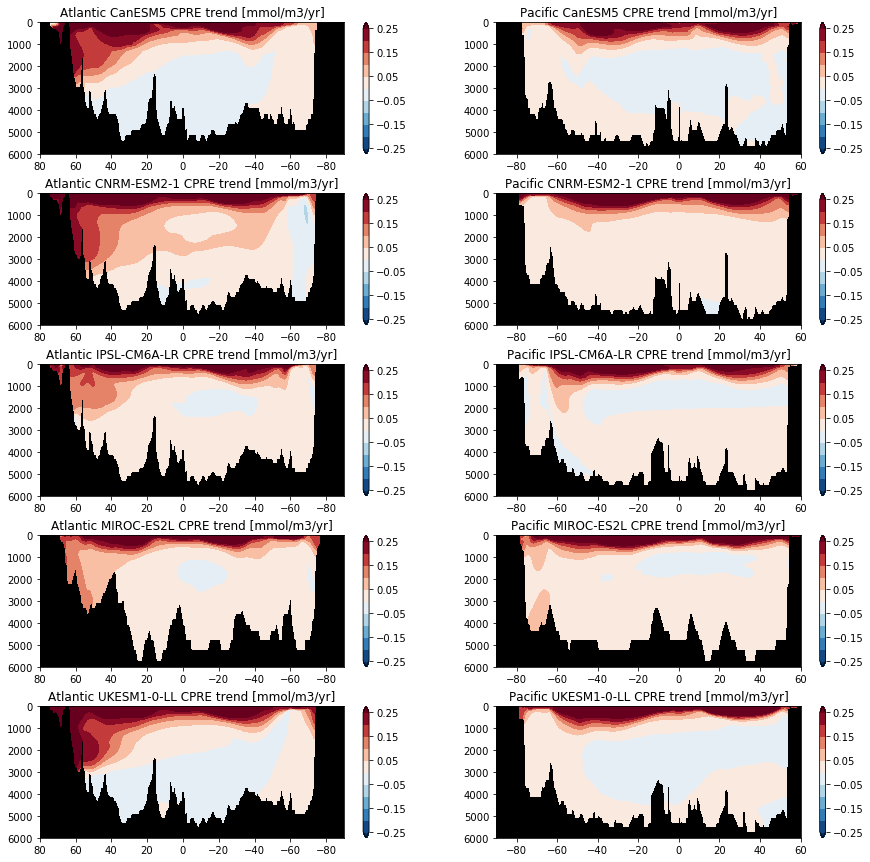

In [13]:
fig, axes = plot_atlantic_pacific_sections(bgc_dict,"cpre",plot_trend=True,
                                           units="[mmol/m3/yr]",fac=1e3,lev=np.arange(-0.25,0.30,0.05),colors='RdBu_r')

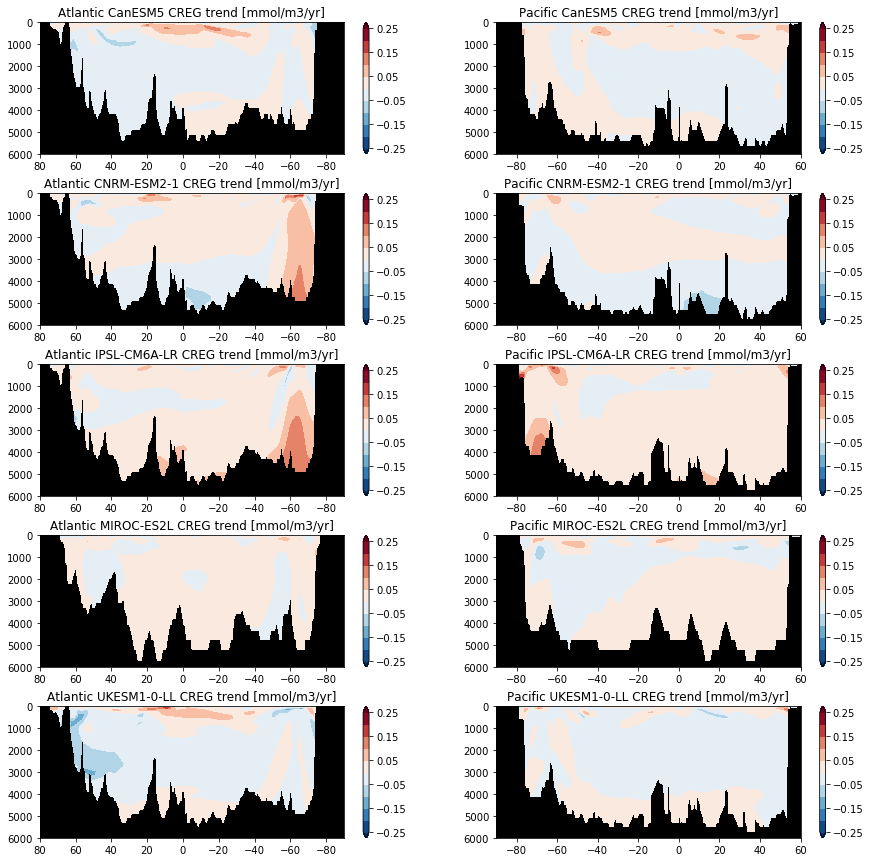

In [14]:
fig, axes = plot_atlantic_pacific_sections(bgc_dict,"creg",plot_trend=True,
                                           units="[mmol/m3/yr]",fac=1e3,lev=np.arange(-0.25,0.30,0.05),colors='RdBu_r')

## Next Steps:

1. Try same analysis for climate change experients (ScenarioMIP).
1. Calculate proper zonal basin averages.
1. Extend the partitioning of `Cpre` to calculate saturated carbon, `Csat`, and disequilibrium carbon, `Cres` after Williams & Follows (2010).
1. Correct AOU for surface `O2` undersaturation.
1. Link to internal anthropogenic CO2 uptake and air-sea CO2 fluxes.